# pytket-dqc Example Usage

In this notebook we gather some example uses of the pytket-dqc package.

## Networks

Near term networks of quantum servers are specified by two properties. The fist is the server coupling, detailing which servers are connected to which others. This is specified by a list of pairs of integers, where each pair signifies that there is a connection between those two servers. The second is the qubits each server contains. This is specified by a dictionary from the server to a list of qubits it contains. 

An example is given below, where blue lines indicate connections between servers, and red lines indicate connections between qubits within servers. The vertex labels are the indexes of the qubits.

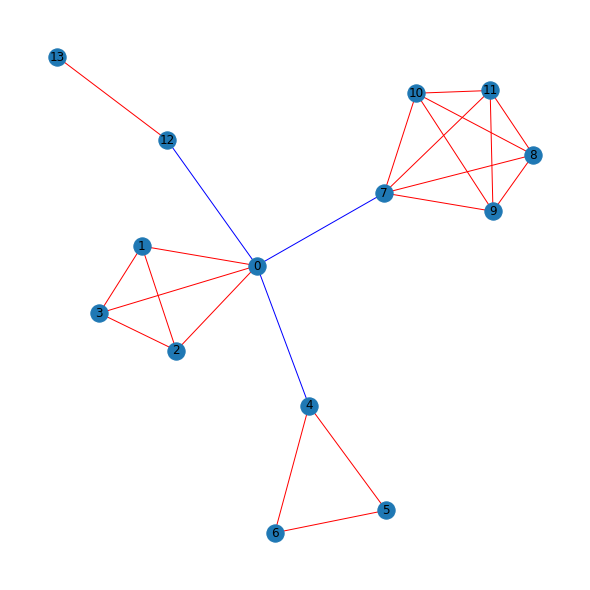

In [1]:
from pytket_dqc.networks import NISQNetwork

network = NISQNetwork([[0,1], [0,2], [0,3]], {0:[0,1,2,3], 1:[4,5,6], 2:[7,8,9,10,11], 3:[12,13]})
network.draw_nisq_network()

## Distributed Circuits

The DistributedCircuits class adds some additional properties and methods to the standard Circuit pytket class. These predominantly relate to a hypergraph representation of the circuit. DistributedCircuits are initialised from a standard tket Circuit object, as seen in the following example. Additional functionality is provided to visualise the corresponding hypergraph. For details on the correspondence between circuits and hypergraphs please see the paper [Automated distribution of quantum circuits via hypergraph partitioning](https://arxiv.org/abs/1811.10972).

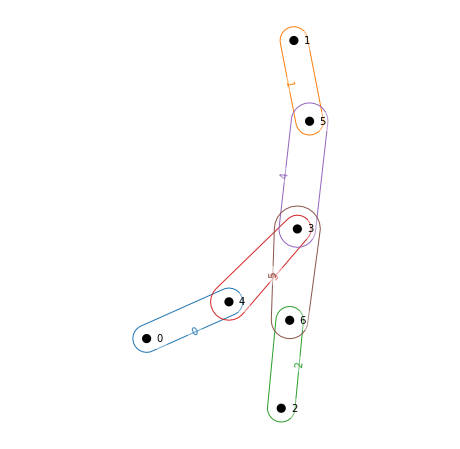

In [2]:
from pytket_dqc.circuits import DistributedCircuit
from pytket.circuit.display import render_circuit_jupyter
from pytket import Circuit

circ = Circuit(4).CZ(0,3).Rz(0.5,3).CZ(1,3).Rz(0.5,3).CZ(2,3).Rz(0.5,3)

dist_circ = DistributedCircuit(circ)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

## Distributors

pytket-dqc provides several distributors, which are themselves a selection of methods to assign qubits and gates to servers. Their aim is to return a placement which minimises the e-bit cost of the resulting implementation.

Here we will work though some example use of these distributors. To do so let's define a simple network.

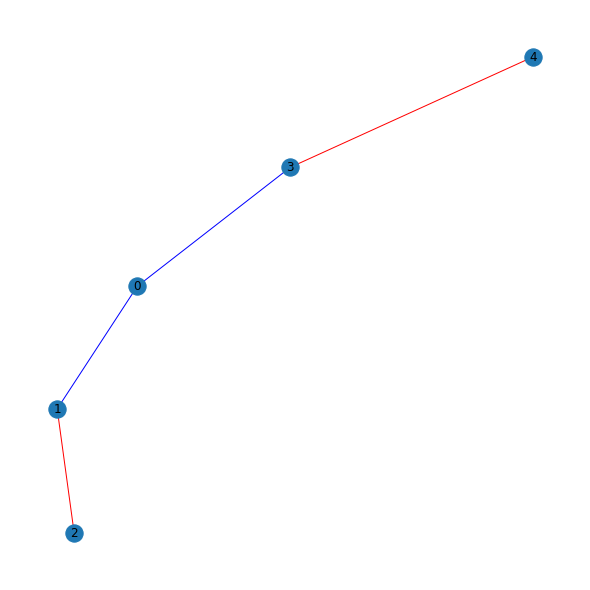

In [3]:
from pytket_dqc.networks import NISQNetwork

network = NISQNetwork([[0,1], [0,2]], {0:[0], 1:[1,2], 2:[3,4]})
network.draw_nisq_network()

Let's also define a circuit to distribute. Some classes of circuits are predefined within pytket-dqc. Cyclic circuits, where CZ gates act in a circle, are one such class of circuits. These circuits are defined by the number of qubits they act on and the number of layers of cycles.

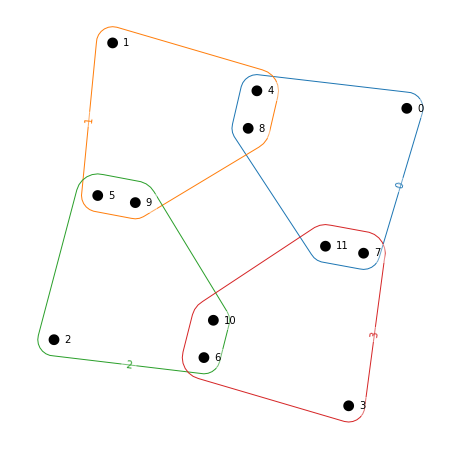

In [4]:
from pytket_dqc.circuits import CyclicDistributedCircuit

dist_circ = CyclicDistributedCircuit(4,2)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

One such is Brute, which performs a brutefoce search of all placements of qubits and gates onto servers, returning the one with the lowest cost. It is the slowest method, but returns the best result every time.

In [5]:
from pytket_dqc.distributors import Brute
import time

distributor = Brute()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 196829/196829 [00:38<00:00, 5142.01it/s]


time to distribute 66.2844181060791
final placement {0: 0, 4: 0, 7: 0, 8: 0, 11: 0, 1: 1, 5: 0, 9: 0, 2: 1, 6: 0, 10: 0, 3: 2}
final placement cost 3


Annealing is another approach, which uses simulated annealing as a means to arrive at a valid placement.

In [6]:
from pytket_dqc.distributors import Annealing

distributor = Annealing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4341.27it/s]

time to distribute 2.337810754776001
final placement {0: 1, 4: 1, 7: 1, 8: 1, 11: 1, 1: 2, 5: 1, 9: 1, 2: 1, 6: 1, 10: 1, 3: 0}
final placement cost 3


GraphPartitioning uses the [Karlsruhe Hypergraph Partitioning Framework](https://kahypar.org/) to derive a placement.

In [7]:
from pytket_dqc.distributors import GraphPartitioning

distributor = GraphPartitioning()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)

time to distributeNo filename for partition file specified 
 0.017303943634033203
final placement {0: 1, 1: 0, 2: 0, 3: 2, 4: 1, 5: 0, 6: 2, 7: 2, 8: 1, 9: 0, 10: 2, 11: 1}


The placements resulting from using the GraphPartitioning method may not be valid on near term networks, as it does not take into consideration limits on the numbers of qubits in each server. It attempts to meet a load balancing condition, which aims to evenly balance the number of gates and qubits that each server must manage. This is not appropriate when the resources themselves are not evenly balanced.

In [8]:
if placement.is_placement(dist_circ, network):
    print("final placement cost", placement.cost(dist_circ, network))
else:
    print("Unfortunatly this is not a valid placement.")

Unfortunatly this is not a valid placement.


Routing makes use of routing and placement and routing techniques available in TKET. Here the network architecture as a whole is interpreted as a backend architecture, with noise on edges between servers set to be very high. Routing is guaranteed to generate a valid placement, and often very quickly. Unfortunately, it does not do a great job of distinguishing between connections within servers and connections between them. This can result in a high e-bit cost. Routing will also alter the circuit

In [9]:
from pytket_dqc.distributors import Routing

distributor = Routing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

time to distribute 0.024387836456298828
final placement {0: 0, 5: 1, 6: 0, 8: 2, 10: 0, 12: 2, 13: 0, 15: 2, 17: 0, 19: 2, 21: 1, 22: 0, 26: 1, 27: 0, 28: 1, 29: 2, 1: 1, 4: 1, 7: 1, 9: 1, 11: 1, 14: 1, 16: 1, 18: 1, 20: 1, 23: 1, 24: 1, 25: 1, 2: 1, 3: 2}
final placement cost 15


## Larger Example

Let's see how far we can push these schemes. Let's create a larger network:

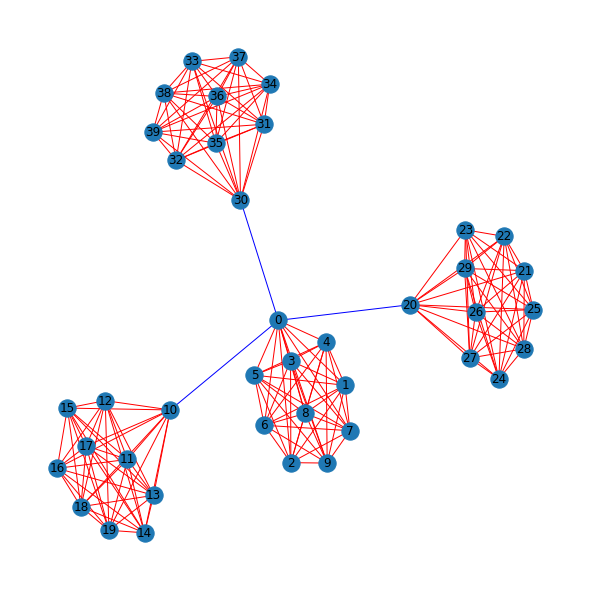

In [10]:
from pytket_dqc.networks import NISQNetwork

network = NISQNetwork([[0,1], [0,2], [0,3]], {0:[i for i in range(10)], 1:[i for i in range(10, 20)], 2:[i for i in range(20,30)], 3:[i for i in range(30,40)]})
network.draw_nisq_network()

and a larger circuit:

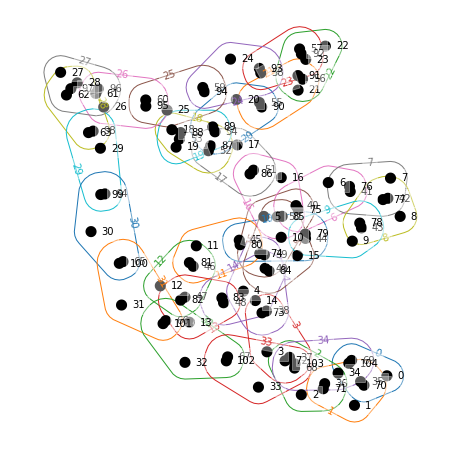

In [11]:
from pytket_dqc.circuits import CyclicDistributedCircuit
from pytket.circuit.display import render_circuit_jupyter

dist_circ = CyclicDistributedCircuit(35,2)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

We have already seen that Brute can be quite slow, so let's not use that here. Let's see how the others perform, starting with Annealing. In this case we see that it performs the slowest of the three schemes. However it does not take an unreasonably long time, and the solution is reasonably good.

In [12]:
from pytket_dqc.distributors import Annealing
import time

distributor = Annealing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 534.88it/s]

time to distribute 18.71461296081543
final placement {0: 2, 35: 2, 69: 2, 70: 2, 104: 2, 1: 2, 36: 2, 71: 2, 2: 2, 37: 2, 72: 2, 3: 2, 38: 2, 73: 2, 4: 2, 39: 3, 74: 3, 5: 3, 40: 3, 75: 3, 6: 1, 41: 1, 76: 1, 7: 1, 42: 1, 77: 1, 8: 1, 43: 1, 78: 1, 9: 1, 44: 1, 79: 1, 10: 1, 45: 1, 80: 1, 11: 1, 46: 0, 81: 0, 12: 2, 47: 2, 82: 2, 13: 2, 48: 3, 83: 3, 14: 3, 49: 3, 84: 3, 15: 3, 50: 3, 85: 3, 16: 3, 51: 0, 86: 0, 17: 0, 52: 0, 87: 0, 18: 3, 53: 3, 88: 3, 19: 3, 54: 3, 89: 3, 20: 3, 55: 0, 90: 0, 21: 0, 56: 0, 91: 0, 22: 0, 57: 0, 92: 0, 23: 0, 58: 0, 93: 0, 24: 3, 59: 3, 94: 3, 25: 3, 60: 3, 95: 3, 26: 3, 61: 3, 96: 3, 27: 0, 62: 0, 97: 0, 28: 2, 63: 0, 98: 0, 29: 0, 64: 0, 99: 0, 30: 0, 65: 0, 100: 0, 31: 0, 66: 0, 101: 0, 32: 0, 67: 0, 102: 0, 33: 0, 68: 0, 103: 0, 34: 2}
final placement cost 15


GraphPartitioning is the quickest, and produces the best result. In this case this is not unsurprising. The servers do have balanced resources, and so we expect a valid solution in this case. The implementation of kahypar is highly optimised and so the result is arrived at very quickly.

In [13]:
from pytket_dqc.distributors import GraphPartitioning

distributor = GraphPartitioning()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)

if placement.is_placement(dist_circ, network):
    print("final placement cost", placement.cost(dist_circ, network))
else:
    print("Unfortunatly this is not a valid placement.")

No filename for partition file specified 
time to distribute 0.06136798858642578
final placement {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 2, 18: 2, 19: 2, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0, 51: 2, 52: 2, 53: 2, 54: 2, 55: 2, 56: 2, 57: 2, 58: 2, 59: 2, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 3, 68: 3, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 2, 87: 2, 88: 2, 89: 2, 90: 2, 91: 2, 92: 2, 93: 2, 94: 2, 95: 3, 96: 3, 97: 3, 98: 3, 99: 3, 100: 3, 101: 3, 102: 3, 103: 3, 104: 1}
final placement cost 6


The placement cost of Routing is the worst, although this is not unreasonably so. Again it arrives a the solution very quickly.

In [14]:
from pytket_dqc.distributors import Routing

distributor = Routing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

time to distribute 2.5930910110473633
final placement {0: 0, 35: 0, 44: 0, 45: 0, 46: 0, 47: 0, 60: 0, 61: 1, 62: 0, 63: 0, 76: 0, 77: 2, 78: 0, 79: 0, 87: 0, 88: 3, 89: 0, 90: 0, 99: 0, 100: 0, 101: 0, 102: 0, 115: 0, 116: 1, 117: 0, 118: 0, 131: 0, 132: 2, 133: 0, 134: 0, 142: 0, 143: 3, 144: 0, 145: 0, 1: 0, 36: 0, 91: 0, 92: 0, 2: 0, 37: 0, 93: 0, 3: 0, 38: 0, 94: 0, 4: 0, 39: 0, 95: 0, 5: 0, 40: 0, 96: 0, 6: 0, 41: 0, 97: 0, 7: 0, 42: 0, 98: 0, 8: 0, 43: 0, 146: 0, 9: 0, 10: 1, 48: 1, 57: 1, 58: 1, 59: 1, 103: 1, 112: 1, 113: 1, 114: 1, 11: 1, 49: 1, 104: 1, 105: 1, 12: 1, 50: 1, 106: 1, 13: 1, 51: 1, 107: 1, 14: 1, 52: 1, 108: 1, 15: 1, 53: 1, 109: 1, 16: 1, 54: 1, 110: 1, 17: 1, 55: 1, 111: 1, 18: 1, 56: 1, 19: 1, 20: 2, 64: 2, 73: 2, 74: 2, 75: 2, 119: 2, 128: 2, 129: 2, 130: 2, 21: 2, 65: 2, 120: 2, 121: 2, 22: 2, 66: 2, 122: 2, 23: 2, 67: 2, 123: 2, 24: 2, 68: 2, 124: 2, 25: 2, 69: 2, 125: 2, 26: 2, 70: 2, 126: 2, 27: 2, 71: 2, 127: 2, 28: 2, 72: 2, 29: 2, 30: 3, 80: 3, 84: 3

Let's finally take a more complex network:

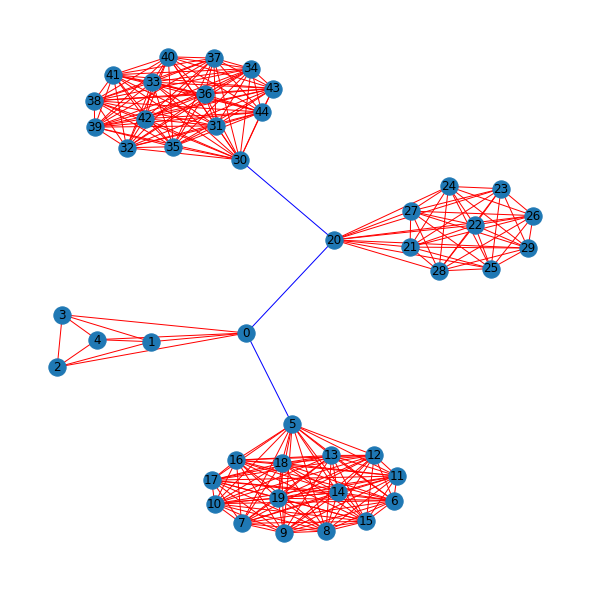

In [15]:
from pytket_dqc.networks import NISQNetwork

network = NISQNetwork([[0,1], [0,2], [2,3]], {0:[i for i in range(5)], 1:[i for i in range(5, 20)], 2:[i for i in range(20,30)], 3:[i for i in range(30,45)]})
network.draw_nisq_network()

and circuit:

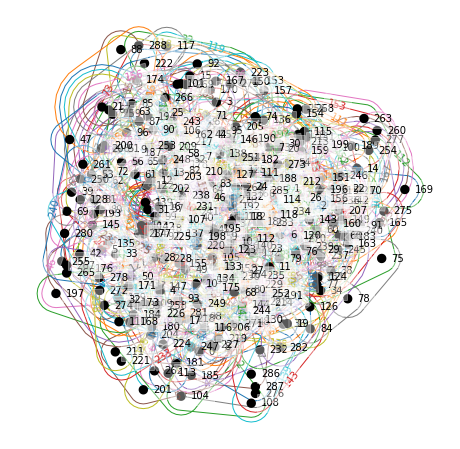

In [16]:
from pytket_dqc.circuits import RegularGraphDistributedCircuit
from pytket.circuit.display import render_circuit_jupyter

dist_circ = RegularGraphDistributedCircuit(34,3,5)
render_circuit_jupyter(dist_circ.circuit)
dist_circ.draw()

Annealing now takes a non-negligible time to find a placement. However, the solution is valid, and of those that generate a valid solution, it is the best

In [17]:
from pytket_dqc.distributors import Annealing
import time

distributor = Annealing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:37<00:00, 102.52it/s]

time to distribute 97.57706499099731
final placement {0: 1, 37: 3, 41: 1, 48: 3, 98: 1, 104: 0, 108: 0, 147: 2, 152: 2, 185: 1, 201: 0, 204: 0, 211: 0, 262: 1, 271: 1, 276: 1, 1: 2, 59: 2, 64: 2, 79: 2, 86: 2, 121: 2, 129: 2, 153: 2, 178: 2, 186: 2, 205: 0, 212: 2, 216: 2, 229: 3, 240: 3, 245: 3, 2: 3, 38: 0, 54: 3, 60: 3, 102: 3, 125: 2, 161: 2, 165: 3, 169: 3, 235: 3, 238: 2, 241: 2, 256: 3, 263: 3, 277: 2, 3: 1, 61: 0, 65: 0, 83: 1, 94: 2, 131: 2, 136: 2, 157: 2, 166: 2, 170: 1, 213: 1, 217: 1, 222: 1, 257: 0, 285: 1, 288: 2, 4: 1, 39: 2, 42: 2, 62: 1, 103: 3, 105: 3, 109: 1, 144: 0, 181: 0, 192: 0, 206: 1, 219: 1, 249: 1, 258: 2, 5: 0, 35: 2, 49: 0, 55: 2, 89: 0, 110: 0, 135: 0, 148: 0, 176: 0, 179: 0, 187: 0, 193: 2, 197: 1, 267: 1, 272: 2, 278: 2, 6: 2, 34: 0, 40: 3, 43: 3, 95: 0, 141: 2, 149: 2, 158: 2, 218: 2, 220: 2, 236: 0, 242: 2, 246: 0, 7: 1, 56: 1, 72: 1, 96: 3, 99: 3, 132: 1, 137: 1, 142: 0, 190: 0, 194: 0, 268: 2, 273: 2, 279: 1, 8: 1, 36: 1, 77: 1, 80: 1, 113: 0, 173: 

GraphPartitioning is again remarkably quick. However, as the loads are unbalanced in this case, the result is not valid.

In [18]:
from pytket_dqc.distributors import GraphPartitioning

distributor = GraphPartitioning()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)

if placement.is_placement(dist_circ, network):
    print("final placement cost", placement.cost(dist_circ, network))
else:
    print("Unfortunatly this is not a valid placement.")

time to distributeNo filename for partition file specified 
 0.17159080505371094
final placement {0: 2, 1: 1, 2: 3, 3: 0, 4: 0, 5: 2, 6: 3, 7: 3, 8: 2, 9: 0, 10: 1, 11: 0, 12: 2, 13: 3, 14: 1, 15: 0, 16: 0, 17: 2, 18: 3, 19: 2, 20: 1, 21: 0, 22: 3, 23: 0, 24: 3, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 3, 32: 2, 33: 2, 34: 3, 35: 1, 36: 3, 37: 2, 38: 3, 39: 1, 40: 3, 41: 2, 42: 1, 43: 3, 44: 0, 45: 1, 46: 3, 47: 0, 48: 2, 49: 2, 50: 1, 51: 3, 52: 1, 53: 1, 54: 2, 55: 1, 56: 0, 57: 3, 58: 1, 59: 1, 60: 2, 61: 1, 62: 1, 63: 0, 64: 1, 65: 1, 66: 1, 67: 0, 68: 2, 69: 2, 70: 2, 71: 1, 72: 0, 73: 2, 74: 1, 75: 3, 76: 1, 77: 2, 78: 3, 79: 0, 80: 2, 81: 2, 82: 1, 83: 0, 84: 3, 85: 1, 86: 1, 87: 1, 88: 0, 89: 2, 90: 1, 91: 1, 92: 0, 93: 2, 94: 0, 95: 1, 96: 0, 97: 2, 98: 2, 99: 3, 100: 1, 101: 0, 102: 3, 103: 0, 104: 2, 105: 0, 106: 1, 107: 3, 108: 2, 109: 0, 110: 2, 111: 3, 112: 1, 113: 2, 114: 1, 115: 3, 116: 0, 117: 0, 118: 1, 119: 0, 120: 3, 121: 1, 122: 3, 123: 3, 124: 0, 125: 3, 126:

Routing too is now noticeably slow, and the solution quite poor.

In [19]:
from pytket_dqc.distributors import Routing

distributor = Routing()

start = time.time()
placement = distributor.distribute(dist_circ, network)
print("time to distribute", time.time() - start)
print("final placement", placement.placement)
print("final placement cost", placement.cost(dist_circ, network))

time to distribute 64.6355493068695
final placement {0: 0, 42: 1, 71: 0, 73: 2, 75: 0, 77: 0, 79: 1, 81: 0, 90: 0, 91: 0, 95: 1, 102: 0, 113: 0, 116: 2, 118: 0, 119: 0, 121: 1, 123: 0, 130: 0, 133: 2, 135: 0, 136: 0, 138: 1, 140: 0, 143: 0, 146: 2, 148: 0, 149: 0, 151: 1, 153: 0, 158: 0, 161: 2, 163: 0, 164: 0, 166: 1, 168: 0, 173: 0, 176: 2, 179: 0, 183: 0, 185: 1, 187: 0, 190: 0, 194: 2, 197: 0, 201: 0, 203: 1, 205: 0, 206: 0, 209: 2, 211: 0, 215: 0, 217: 1, 219: 0, 226: 2, 237: 0, 239: 2, 241: 0, 243: 0, 244: 1, 245: 0, 246: 0, 248: 2, 251: 0, 252: 1, 260: 0, 261: 2, 262: 0, 263: 0, 265: 1, 267: 0, 279: 2, 282: 0, 284: 1, 286: 0, 293: 0, 295: 2, 297: 0, 299: 0, 301: 1, 303: 0, 312: 0, 315: 2, 317: 0, 318: 0, 321: 1, 323: 0, 330: 0, 331: 1, 332: 0, 333: 0, 334: 2, 335: 0, 336: 0, 338: 1, 340: 0, 342: 0, 358: 0, 361: 1, 364: 0, 365: 0, 367: 2, 369: 0, 372: 0, 374: 1, 376: 0, 377: 0, 380: 2, 383: 0, 390: 0, 392: 1, 394: 0, 396: 0, 400: 2, 404: 0, 413: 0, 415: 1, 417: 0, 418: 0, 420: 2,